# Evaluate location and seasonality of formed polynyas / sea ice formation

In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import glob
import cmocean
import sys
sys.path.append('/home/users/birgal/')
from nemo_python_git.plots import circumpolar_plot, finished_plot
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [5]:
run_folder  = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/ERA5_test4_cont/'
nemo_mesh   = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/mesh_mask-20240305.nc'
nemo_domain = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/domain_cfg-20240305.nc'

In [6]:
# load files:
nemo_mesh_ds = xr.open_dataset(nemo_mesh)
icemod_files = glob.glob(f'{run_folder}/*icemod*')
nemo_ds      = xr.open_mfdataset(icemod_files) 

In [75]:
def plot_ocean(nemo_mesh, file_var):   
    lon_plot = np.ma.masked_where(nemo_mesh.tmask.isel(nav_lev=0) == 0, nemo_mesh.nav_lon.values)
    lat_plot = np.ma.masked_where(nemo_mesh.tmask.isel(nav_lev=0) == 0, nemo_mesh.nav_lat.values)
    plot_var = np.ma.masked_where(nemo_mesh.tmask.isel(nav_lev=0) == 0, file_var.values)
    return lon_plot, lat_plot, plot_var 

In [67]:
def plot_land(nemo_mesh, file_var):
    lon_plot = np.ma.masked_where(nemo_mesh.tmask.isel(nav_lev=0) != 0, nemo_mesh.nav_lon.values)
    lat_plot = np.ma.masked_where(nemo_mesh.tmask.isel(nav_lev=0) != 0, nemo_mesh.nav_lat.values)
    plot_var = np.ma.masked_where(nemo_mesh.tmask.isel(nav_lev=0) != 0, file_var.values)
    return lon_plot, lat_plot, plot_var 

### Visualize regions of sea ice production

In [ ]:
# calculate annual cumulative sea ice production and compare with: https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2007GL032903

In [189]:
nemo_ds

<xarray.Dataset>
Dimensions:               (y: 453, x: 1440, time_counter: 264, nvertex: 4,
                           ncatice: 5, axis_nbounds: 2)
Coordinates:
    nav_lat               (y, x) float32 dask.array<chunksize=(453, 1440), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(453, 1440), meta=np.ndarray>
  * ncatice               (ncatice) float32 1.0 2.0 3.0 4.0 5.0
    time_centered         (time_counter) datetime64[ns] dask.array<chunksize=(12,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 1979-01-16T12:00:00 ....
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables: (12/57)
    bounds_nav_lon        (time_counter, y, x, nvertex) float32 dask.array<chunksize=(12, 453, 1440, 4), meta=np.ndarray>
    bounds_nav_lat        (time_counter, y, x, nvertex) float32 dask.array<chunksize=(12, 453, 1440, 4), meta=np.ndarray>
    area                  (time_counter, y, x) float32 dask.array<chunksize=(12, 453, 1440), meta=np.ndarray>
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    simsk                 (time_counter, y, x) float32 dask.array<chunksize=(12, 453, 1440), meta=np.ndarray>
    ...                    ...
    vfxopw                (time_counter, y, x) float32 dask.array<chunksize=(12, 453, 1440), meta=np.ndarray>
    vfxdyn                (time_counter, y, x) float32 dask.array<chunksize=(12, 453, 1440), meta=np.ndarray>
    simskcat              (time_counter, ncatice, y, x) float32 dask.array<chunksize=(12, 5, 453, 1440), meta=np.ndarray>
    snthicat              (time_counter, ncatice, y, x) float32 dask.array<chunksize=(12, 5, 453, 1440), meta=np.ndarray>
    siconcat              (time_counter, ncatice, y, x) float32 dask.array<chunksize=(12, 5, 453, 1440), meta=np.ndarray>
    sithicat              (time_counter, ncatice, y, x) float32 dask.array<chunksize=(12, 5, 453, 1440), meta=np.ndarray>
Attributes:
    name:         eANT025.L121_1m_19790101_19791231_icemod
    description:  ice variables
    title:        ice variables
    Conventions:  CF-1.6
    timeStamp:    2024-Mar-28 14:21:43 GMT
    uuid:         2b209d7c-1e7a-498b-a516-42896fc71f9e

In [164]:
# ice_growth = xr.where(nemo_ds.vfxice >= 0, np.nan, (nemo_ds.time_counter.dt.days_in_month*3600*24)*nemo_ds.vfxice*nemo_ds.area)
ice_growth = xr.where(nemo_ds.vfxice >= 0, np.nan, (nemo_ds.time_counter.dt.days_in_month*3600*24)*nemo_ds.vfxice)

# average over full time series:
annual_icegrowth = ice_growth.groupby('time_counter.year').sum('time_counter')
annual_maxicevol = nemo_ds.sivolu.groupby('time_counter.year').max('time_counter')
masked_ice_growth = xr.where(annual_ice_growth==0, np.nan, -1*annual_ice_growth)

# average 1992-2001 to compare with Tamura et al. (2008):
Tamura_icegrowth = ice_growth.sel(time_counter=slice('1992-01-01', '2002-01-01')).groupby('time_counter.year').sum('time_counter')
Tamura_ice_growth = xr.where(Tamura_icegrowth>=-4000, np.nan, -1*Tamura_icegrowth).mean('year')
# (time_counter, y, x) long_name : ice-ocean mass flux from ice melt/growth (neg = growth)

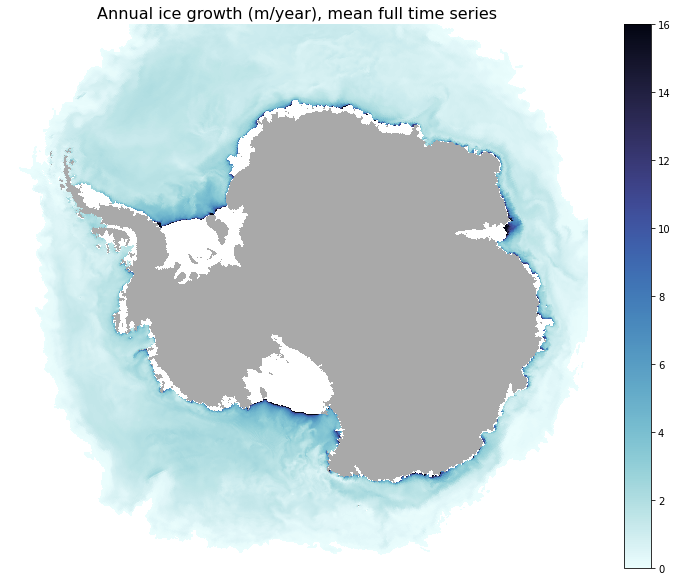

In [170]:
fig, ax = plt.subplots(1,1, figsize=(13,10))
circumpolar_plot(masked_ice_growth*1e-3, nemo_mesh_ds.isel(time_counter=0), ax=ax, make_cbar=True, return_fig=False, \
                 ctype=cmocean.cm.ice_r, lat_max=-62, vmin=0, vmax=16, title='Annual ice growth (m/year), mean full time series')

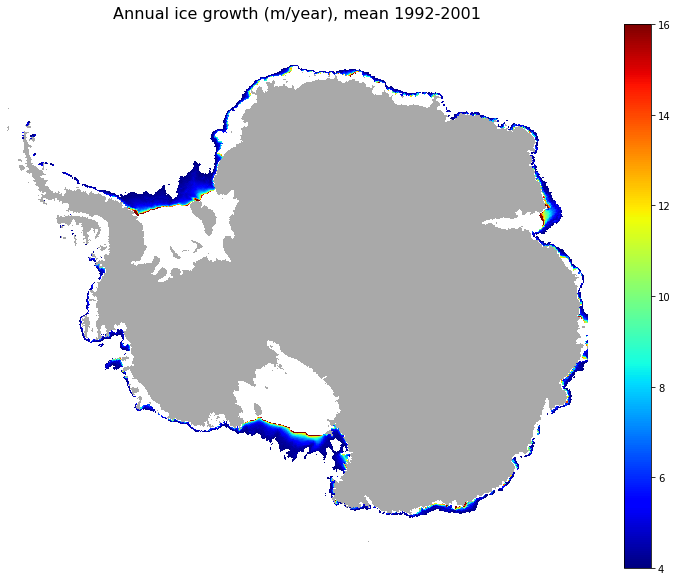

In [161]:
fig, ax = plt.subplots(1,1, figsize=(13,10))
circumpolar_plot(Tamura_ice_growth*1e-3, nemo_mesh_ds.isel(time_counter=0), ax=ax, make_cbar=True, return_fig=False, \
                 ctype='jet', lat_max=-66, vmin=4, vmax=16, title='Annual ice growth (m/year), mean 1992-2001')

# kg/m2/year * 1e-3 m3 / kg = m/year
        # fig.tight_layout()

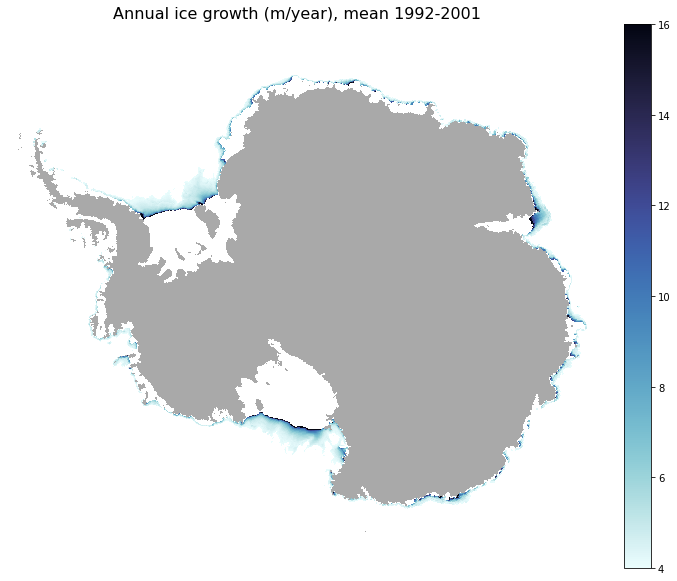

In [163]:
fig, ax = plt.subplots(1,1, figsize=(13,10))
circumpolar_plot(Tamura_ice_growth*1e-3, nemo_mesh_ds.isel(time_counter=0), ax=ax, make_cbar=True, return_fig=False, \
                 ctype=cmocean.cm.ice_r, lat_max=-65, vmin=4, vmax=16, title='Annual ice growth (m/year), mean 1992-2001')
# kg/m2/year * 1e-3 m3 / kg = m/year
        # fig.tight_layout()

(100.0, 453.0)

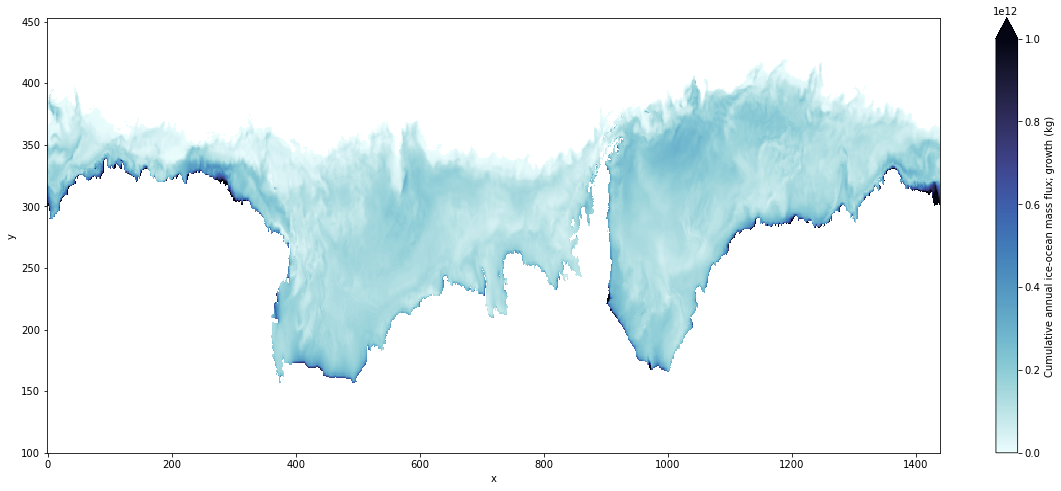

In [52]:
fig, ax = plt.subplots(1,1, figsize=(20,8))
masked_ice_growth.plot(ax=ax, cmap=cmocean.cm.ice_r, vmin=0, vmax=1e12, \
                       cbar_kwargs={'label':'Cumulative annual ice-ocean mass flux; growth (kg)', 'extend':'max'})
ax.set_ylim(100,453)

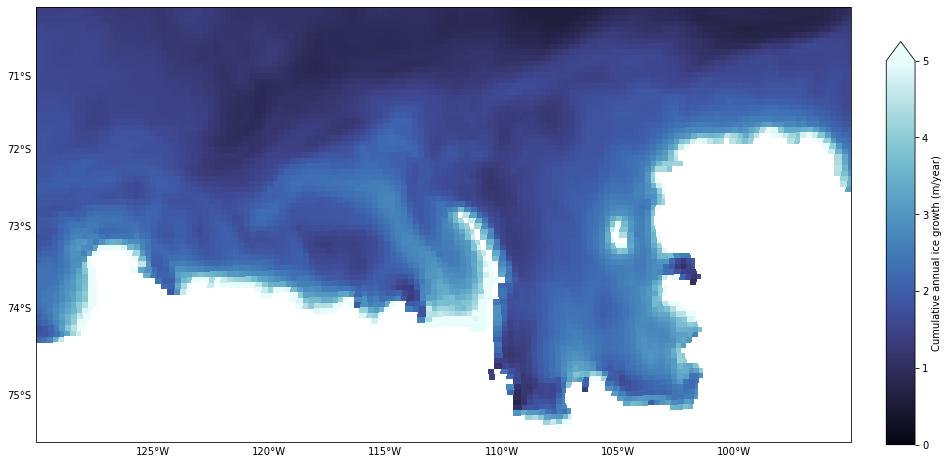

In [179]:
nemo_sub = nemo_mesh_ds.isel(time_counter=0,x=slice(450,900),y=slice(130,350))
ice_sub  = masked_ice_growth.isel(x=slice(450,900),y=slice(130,350))*1e-3

fig, ax = plt.subplots(1,1, figsize=(20,8), subplot_kw={'projection':ccrs.Mercator(latitude_true_scale=-70)})

ax.set_extent([-95, -130, -75.5, -70], ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True);
gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;

lon_plt, lat_plt, var_plt    = plot_ocean(nemo_sub, ice_sub)
lon_land, lat_land, land_plt = plot_land(nemo_sub, ice_sub)
img = ax.pcolormesh(lon_plt, lat_plt, var_plt, transform=ccrs.PlateCarree(), rasterized=True, cmap=cmocean.cm.ice, vmin=0, vmax=5)
# ax.pcolormesh(lon_land, lat_land, land_plt, transform=ccrs.PlateCarree(), rasterized=True, cmap=cl.ListedColormap(['DarkGrey']))
# ax.set_title(title)
        
cax = fig.add_axes([0.82, 0.12, 0.02, 0.7])    
plt.colorbar(img, cax=cax, extend='max', label='Cumulative annual ice growth (m/year)')

### Visualize annual sea ice formation cycle and interannual variation

In [182]:
annual_maxicevol = nemo_ds.sivolu.groupby('time_counter.year').max('time_counter')

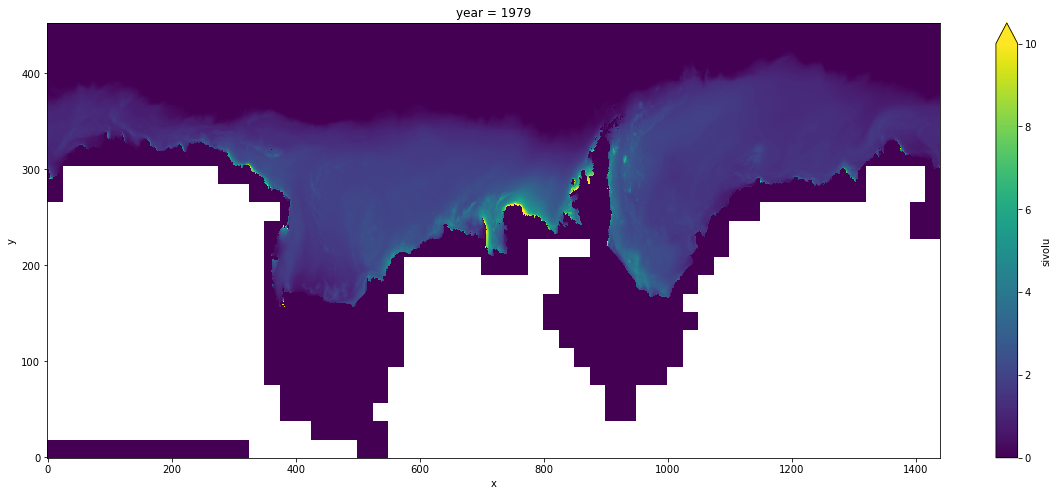

In [188]:
annual_maxicevol.isel(year=0).plot(figsize=(20,8), vmax=10)

### Compare maximum interannual sea ice extent in the model and based on satellite (do the same for total ice area)

1) Make function that identifies the 'continuous' ice edge for any particular month (plot on top of sea ice concencentration animation to check)
2) Identify annual maxima in ice extent (based on total ice area?) and plot as outlines of ice edge on one figure
3) Load similar information for satellite data

### Visualize sea ice production and concentration for the Amundsen Sea
Evaluate seasonality and area with: https://tc.copernicus.org/articles/17/457/2023/tc-17-457-2023.pdf

In [190]:
nemo_ds.siconc

<xarray.DataArray 'siconc' (time_counter: 264, y: 453, x: 1440)>
dask.array<concatenate, shape=(264, 453, 1440), dtype=float32, chunksize=(12, 453, 1440), chunktype=numpy.ndarray>
Coordinates:
    nav_lat        (y, x) float32 dask.array<chunksize=(453, 1440), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(453, 1440), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(12,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 1979-01-16T12:00:00 ... 2000...
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_ice_area_fraction
    long_name:           Sea-ice area fraction
    units:               
    online_operation:    average
    interval_operation:  1350 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 1350 s)
    cell_measures:       area: area

In [ ]:
# ice_growth = xr.where(nemo_ds.vfxice >= 0, np.nan, (nemo_ds.time_counter.dt.days_in_month*3600*24)*nemo_ds.vfxice*nemo_ds.area)
ice_conc = xr.where(nemo_ds.vfxice >= 0, np.nan, (nemo_ds.time_counter.dt.days_in_month*3600*24)*nemo_ds.vfxice)

# average over full time series:
annual_icegrowth = ice_growth.groupby('time_counter.year').sum('time_counter')
annual_maxicevol = nemo_ds.sivolu.groupby('time_counter.year').max('time_counter')
masked_ice_growth = xr.where(annual_ice_growth==0, np.nan, -1*annual_ice_growth)

In [82]:
def plot_amundsen_sea(fig, ax, var, title=None, ctype=cmocean.cm.ice, vlim=(0,1), nemo_mesh=nemo_mesh_ds, labelname=''):
    
    ax.set_extent([-95, -130, -75.5, -70], ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True);
    gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;

    lon_plt, lat_plt, var_plt    = plot_ocean(nemo_mesh, var)
    lon_land, lat_land, land_plt = plot_land(nemo_mesh, var)
    img = ax.pcolormesh(lon_plt, lat_plt, var_plt, transform=ccrs.PlateCarree(), rasterized=True, cmap=ctype, vmin=vlim[0], vmax=vlim[1])
    ax.pcolormesh(lon_land, lat_land, land_plt, transform=ccrs.PlateCarree(), rasterized=True, cmap=cl.ListedColormap(['DarkGrey']))
    ax.set_title(title)
        
    cax = fig.add_axes([0.92, 0.72, 0.025, 0.15])    
    plt.colorbar(img, cax=cax, extend='both', label=labelname)
    
    return fig, ax

In [65]:
nemo_sub = nemo_mesh_ds.isel(x=slice(450, 900), y=slice(130,350), time_counter=0)

In [ ]:
fig, ax = plt.subplots(4,3, figsize=(15,15), subplot_kw={'projection':ccrs.Mercator(latitude_true_scale=-70)})

plot_amundsen_sea(fig, ax[0,0], var.isel(time_counter=0, x=slice(450, 900), y=slice(130,350)), title='Month 1', nemo_mesh=nemo_sub)

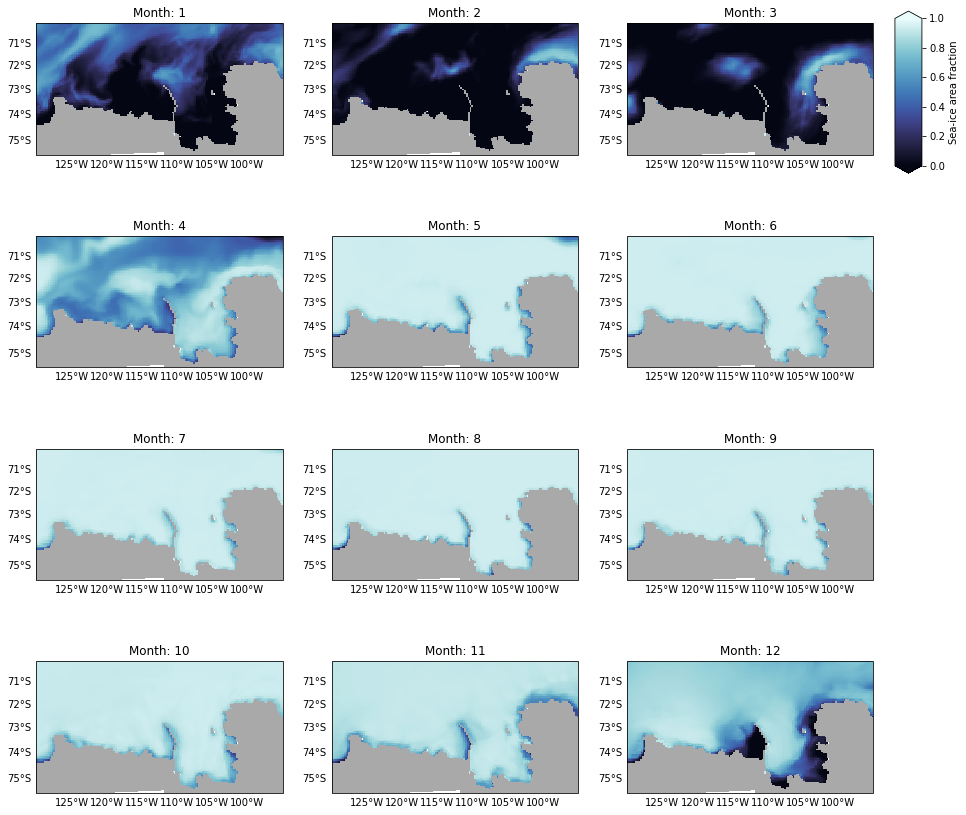

In [77]:
# fig, ax = plt.subplots(4,3, figsize=(15,15), subplot_kw={'projection':ccrs.Mercator(latitude_true_scale=-70)})

# for axis in ax.ravel():
#     axis.set_extent([-95, -130, -75.5, -70], ccrs.PlateCarree())
#     gl = axis.gridlines(draw_labels=True);
#     gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;

# for month in range(0,12):
#     lon_plt, lat_plt, var_plt    = mask_land(mesh_sub, sea_ice_ds.siconc.isel(time_counter=month, x=slice(450, 900), y=slice(130,350)))
#     lon_land, lat_land, land_plt = plot_land(mesh_sub, sea_ice_ds.siconc.isel(time_counter=month, x=slice(450, 900), y=slice(130,350)))
#     img = ax.ravel()[month].pcolormesh(lon_plt, lat_plt, var_plt, transform=ccrs.PlateCarree(), rasterized=True, cmap=cmocean.cm.ice, vmin=0, vmax=1)
#     ax.ravel()[month].pcolormesh(lon_land, lat_land, land_plt, transform=ccrs.PlateCarree(), rasterized=True, cmap=cl.ListedColormap(['DarkGrey']))
#     ax.ravel()[month].set_title(f'Month: {month+1}')
    
# cax = fig.add_axes([0.92, 0.72, 0.025, 0.15])    
# plt.colorbar(img, cax=cax, extend='both', label=sea_ice_ds.siconc.long_name)